## Pixel wise correlations over peatland regions

**Inputs**
- correlation, slope, intercept, standard error and p-value maps from Calculate_PW_correlation.ipynb
- vegetation map

**Methods**
- regrid vegetation map to the same area as the correlation maps
- mask for: (i) peatland only pixels, (ii) palm, (iii) hardwood
- mask for high correlation, low p-values (<0.05)
- investigate differences in correlations, slopes, intercepts between the above 3 categories

**Outputs**
- average equations over each category
- masked maps for equations


In [1]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Declare data and output directories here

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
# reading in pixel wise correlations
corrs_da = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
pvals_da = xr.open_dataset(ALOS_OUT + 'pvals_da_HH_new.nc')
stderrs_da = xr.open_dataset(ALOS_OUT + 'stderrs_da_HH_new.nc')
gradients_da = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
intercepts_da = xr.open_dataset(ALOS_OUT + 'intercepts_da_HH_new.nc')

# reading in the vegetation map (download from: https://congopeat.net/maps)
# smoothed version
land_type = xr.open_rasterio(WRKDIR2 + 'Veg_maps/Crezee_2022_Smoothed_7x7_Classification_Most_likely_class.tif')

In [3]:
# opening the original HH timeseries
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')

# calculating the minimum backscatter values across the set of images - used to mask for permanent water bodies.
HH_min = HH_db_100m.min(dim='time')

In [ ]:
lt = land_type.rename({'x':'lon','y':'lat'})
lt = lt[0].to_dataset(name='type')

# reversing lat values
lt = lt.reindex(lat=lt.lat[::-1])
lt

<xarray.DataArray 'lat' ()>
array(-1.08780671) <xarray.DataArray 'lat' ()>
array(2.75877934) <xarray.DataArray 'lon' ()>
array(16.11430745) <xarray.DataArray 'lon' ()>
array(19.90519795)


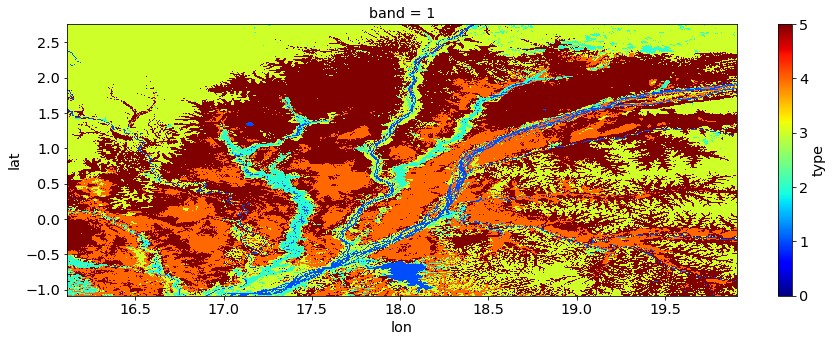

In [5]:
# cutting out the land-type map to the extents of the ALOS data

min_lat = HH_db_100m['lat'].min()
max_lat = HH_db_100m['lat'].max()
min_lon = HH_db_100m['lon'].min()
max_lon = HH_db_100m['lon'].max()

print(min_lat, max_lat,min_lon, max_lon)

lt_sub = lt['type'].sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))
lt_sub[::5,::5].plot(vmin=0)

In [ ]:
%%time
# now interpolating the landtype map to the same resolution as the ALOS derived 100m data
lt_100m = lt_sub.interp_like(HH_db_100m, method='nearest')
lt_100m.to_netcdf(ALOS_OUT + 'landtype_100m.nc')
lt_100m

### Using the land-type map to mask the pixel-wise correlation maps
- they are now on the same grids and can be compared directly

In [ ]:
# reformatting the land type array - dropping unnecessary band and converting from data array to dataset
lt_100m = lt_100m.drop_vars('band').to_dataset(name='type')
lt_100m

In [8]:
# reformatting the variable names to something more sensible
gradients_ds = gradients_da.rename_vars({'__xarray_dataarray_variable__':'gradient'})
intercepts_ds = intercepts_da.rename_vars({'__xarray_dataarray_variable__':'intercept'})
pvals_ds = pvals_da.rename_vars({'__xarray_dataarray_variable__':'pvalues'})
corrs_ds = corrs_da.rename_vars({'__xarray_dataarray_variable__':'correlation'})
stderrs_ds = stderrs_da.rename_vars({'__xarray_dataarray_variable__':'stderr'})

# dropping the unnecessary time dim
gradients_ds = gradients_ds['gradient'][0].to_dataset(name='gradient')
intercepts_ds = intercepts_ds['intercept'][0].to_dataset(name='intercept')
pvals_ds = pvals_ds['pvalues'][0].to_dataset(name='pvalues')
corrs_ds = corrs_ds['correlation'][0].to_dataset(name='correlation')
stderrs_ds = stderrs_ds['stderr'][0].to_dataset(name='stderr')

In [ ]:
# putting the HH lat into the same order as the pw correlations
HH_ds = HH_min.reindex(lat = list(reversed(HH_min.lat)))
HH_ds

In [ ]:
%%time
# mask with pvalues <0.05
# potentially different equations could be used for palm and hardwood swamp
ds = gradients_ds.where(pvals_ds['pvalues']<0.05)
ds_i  = intercepts_ds.where(pvals_ds['pvalues']<0.05)

ds2 = corrs_ds.where(pvals_ds['pvalues']<0.05)

# masking for very high correlation pixels to get the relationship 
# between net water and backscatter when perfectly rainfed
# not currently using a correlation mask. 
#threshold =0.7

#ds = ds.where(corrs_ds['correlation']>threshold)
#ds_i = ds_i.where(corrs_ds['correlation']>threshold)

#ds2 = ds2.where(corrs_ds['correlation']>threshold)

## Could further mask for standard error
#stderr_threshold = 30  # 3cm in net water calculation (what is an acceptable standard error?)


# masking for peat pixels
gradients_peat = ds.where(lt_100m['type'].isin([4,5]))
gradients_ps = ds.where(lt_100m['type'].isin([4]))
gradients_hws = ds.where(lt_100m['type'].isin([5]))

corrs_peat = ds2.where(lt_100m['type'].isin([4,5]))
corrs_ps = ds2.where(lt_100m['type'].isin([4]))
corrs_hws = ds2.where(lt_100m['type'].isin([5]))

intercepts_peat = ds_i.where(lt_100m['type'].isin([4,5]))
intercepts_ps = ds_i.where(lt_100m['type'].isin([4]))
intercepts_hws = ds_i.where(lt_100m['type'].isin([5]))

# masking for permanent water bodies
ds = gradients_peat['gradient'].where(HH_ds>-12,np.nan)

gradients_peat = ds.rename({'db':'gradient'})

# saving to netcdf
#gradients_peat.to_netcdf(ALOS_OUT + 'gradients_peat.nc')  # this is used to calculate the HH daily interpolation
#corrs_peat.to_netcdf(ALOS_OUT + 'corrs_peat.nc')
lt_100m.to_netcdf(ALOS_OUT + 'landtype_100m.nc')
#pvals_ds.to_netcdf(ALOS_OUT + 'pvals_ds.nc')

In [14]:
# masking HH_db_100m for use in the daily interpolation 
# peat land types and pvalue <0.05 and permanent water bodies
HH_masked = HH_db_100m.where(lt_100m['type'].isin([4,5]))
HH_masked = HH_masked.where(pvals_ds['pvalues']<0.05)
HH_masked = HH_masked.where(HH_min>-11,np.nan)

#HH_masked['db'][0][::5,::5].plot(vmin=-11)
HH_masked.to_netcdf(ALOS_OUT + 'HH_db_100m_masked.nc')

# masked for peatland only (to compare the accuracy of the linear interpolation with the NW daily interpolation)
HH_masked_l = HH_db_100m.where(lt_100m['type'].isin([4,5]))
HH_masked_l = HH_masked_l.where(HH_min>-11,np.nan)
HH_masked_l.to_netcdf(ALOS_OUT + 'HH_db_100m_masked_l.nc')
                             

### Statistical summary 

<xarray.DataArray 'gradient' ()>
array(65.99812243)

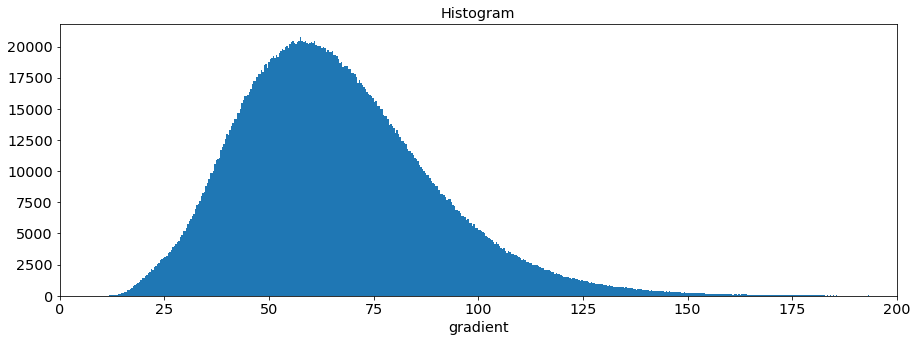

In [22]:
gradients_peat['gradient'].plot.hist(bins=1000, xlim = (0,200));
gradients_peat['gradient'].mean()

In [ ]:
print (gradients_ps['gradient'].mean())
print (gradients_ps['gradient'].median())
print (gradients_ps['gradient'].std())
print (intercepts_ps['intercept'].mean())
print (intercepts_ps['intercept'].median())
print (intercepts_ps['intercept'].std())
gradients_ps['gradient'].plot.hist(bins=1000, xlim = (0,200));

### Run these codes before going on to the next part of this code
The code following here uses outputs from the below mentioned codes, so run those first

#### Next codes:
- Grid_interpolate_HH_to_daily.ipynb
- Combine_linear_and_rainfed_daily_interpolations.ipynb



### Testing daily output HH

In [13]:
# opening the interpolated to daily HH outputs
HH_linear = xr.open_dataset(ALOS_OUT + 'HH_linear_subset.nc')  # output from HH_linear_interpolation.ipynb
#HH_daily_1054 = xr.open_dataset(ALOS_OUT + 'HH_daily_m_1054_Aug_to_Dec_2020.nc')
HH_daily_nearest = xr.open_dataset(ALOS_OUT + 'HH_daily_m_grid_nearest_full_ts.nc')


In [14]:
%%time
# masking HH nearest interpolation for water bodies (could do this before interpolation)
HH_daily = HH_daily_nearest.where(HH_min>-11,np.nan)

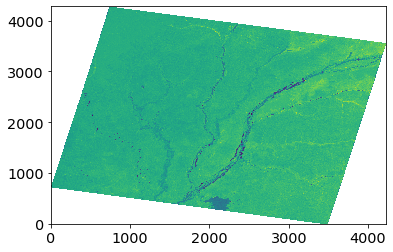

In [48]:
from matplotlib import pyplot as plt, animation
from matplotlib.animation import FuncAnimation

%matplotlib inline
from IPython.display import HTML, display

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    graph_data = ds['db'][i,:,:]
    ax1.pcolormesh(graph_data)
    
ani = FuncAnimation(fig,animate,5)
HTML(ani.to_jshtml())